In [28]:
import pandas as pd


#1. Importer le fichier CSV
data = pd.read_csv("../clean_data/ValeursFoncieres_enrichies.csv",dtype={
                       "Code commune": str,
                        "No plan": str,
                        "Code type local": str,
                        "Code departement": str,
                        "Commune": str,
                        })


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_8716\174245696.py:5: DtypeWarning: Columns (3,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../clean_data/ValeursFoncieres_enrichies.csv",dtype={


In [29]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528826 entries, 0 to 528825
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Date mutation              528826 non-null  object 
 1   Nature mutation            528826 non-null  object 
 2   Valeur fonciere            528826 non-null  float64
 3   Code postal                528826 non-null  object 
 4   Commune                    528826 non-null  object 
 5   Code departement           528826 non-null  object 
 6   Code commune               528826 non-null  object 
 7   Section                    528798 non-null  object 
 8   No plan                    528826 non-null  object 
 9   Code type local            528826 non-null  object 
 10  Type local                 528826 non-null  object 
 11  Surface reelle bati        528794 non-null  float64
 12  Nombre pieces principales  528794 non-null  float64
 13  Surface terrain            33

Définir les variables cibles et prédictives

In [30]:
y = data['Valeur fonciere']

X = data[[
    'Code postal',
    'Code commune',
    'Code departement',
    'CodeINSEE',
    'Type local',
    'Surface reelle bati',
    'Nombre pieces principales',
    'Surface terrain',
    'Population',
    'dens_pop'
]]

X = X.dropna()
y = y.loc[X.index]

Classer les colonnes catégorielles et numériques

In [ ]:
cat_cols = ['Code departement', 'Type local']
num_cols = ['Surface reelle bati', 'Nombre pieces principales', 'Surface terrain', 'Population', 'dens_pop']

Préparation des données d'entrées

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(transformers=[
    ('num',StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

Pipeline global avec modèle

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipeline =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1))
])

Decoupage du jeu d'entrainement

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [51]:
for col in cat_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

In [52]:
for col in cat_cols:
    print(f"{col} : {X_train[col].nunique()} modalités")

Code departement : 67 modalités
Type local : 2 modalités
Code postal : 4191 modalités


In [53]:
X_small = X_train.sample(20000, random_state=0)
y_small = y_train.loc[X_small.index]

In [54]:
pipeline.fit(X_small, y_small)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Evaaluation des performances

In [55]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = pipeline.predict(X_test)

print("MSE: ", mean_squared_error(y_test, y_pred))
print("R²: ", r2_score(y_test, y_pred))

MSE:  7420745143.653274
R²:  0.40578833209671306


R² ≈ 0.35 signifie que ton modèle n'explique qu'environ 35 % de la variance du prix immobilier.

En clair, les performances sont faibles : le modèle est peu précis et les prédictions sont loin des vraies valeurs.

Ce code affiche un nuage de points pour comparer les valeurs réelles (y_test) aux valeurs prédites (y_pred) d’un modèle.
Il trace aussi une droite rouge en pointillés représentant la perfection (y = x), pour visualiser l’écart entre les prédictions et la réalité.
On échantillonne 2 000 points pour que le graphique reste lisible.

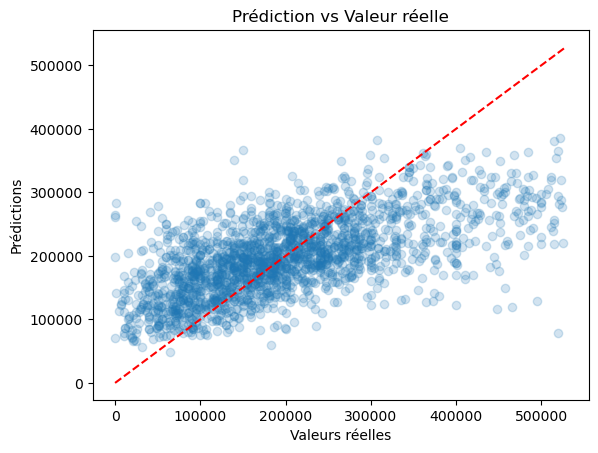

In [61]:
import matplotlib.pyplot as plt
import numpy as np

idx = np.random.choice(len(y_test), size = 2000, replace=False)

plt.scatter(y_test.iloc[idx], y_pred[idx], alpha=0.2)
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Prédiction vs Valeur réelle")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()
